## Week 8 Homework

---

### Q1: derive the following

1. $p(\boldsymbol \beta | \textbf{y}, \textbf{X}, \Sigma=\sigma^2 I)$ for the **linear regression model** likelihood proportional to $\exp \left(-{\frac {1}{2}}(\mathbf {y} -\mathbf{X\boldsymbol \beta})^\top \Sigma^{-1}(\mathbf {y} - \mathbf{X\boldsymbol\beta})\right)$ and a $\mathcal{MVN}(\boldsymbol\beta_0, \boldsymbol\Sigma_\beta)$ for $\boldsymbol\beta$

2. The analytical posterior distribution for $\sigma^2$ the **error variance** of a **linear regression model** with **design matrix** $\mathbf{X}$ assuming $\sigma^2$ has an **inverse-gamma** prior distribution with parameters $\alpha^*$ and $\beta^*$ (unrelated to $\boldsymbol \beta$).


*Note though that Bayesians do not optimize posterior distributions, they sample from them; but, nonetheless, the posterior distributions serve to provided 'regularizeations' of the likelihood through the prior.*


1.

Get posterior of $\beta$ by combining liklihood and prior:

$p(\boldsymbol \beta | \textbf{y}, \textbf{X}, \sigma^2) ∝ \exp \left(-{\frac {1}{2}}(\mathbf {y} -\mathbf{X\boldsymbol \beta})^\top (\mathbf {y} - \mathbf{X\boldsymbol\beta})\right) × \exp \left(-{\frac {1}{2}}(\beta -\beta_0) \Sigma^{-1}_{\beta}(\beta - \beta_0)\right) $

Combining the two exponentials in quadratic form, the posterior for β is also a multivariate normal.

$β|y,X,σ^2 ~ N(μ_\beta , Σ_{\beta | y})$

,where,
- Posterior covariance:
$Σ_{\beta | y} = (\frac{1}{σ^2}X^{T}X + Σ^{-1}_{\beta})^{-1}$
- Posterior mean:
$\mu_{\beta} = Σ_{\beta | y}(\frac{1}{σ^2}X^{T}y + Σ^{-1}_{\beta}\beta_0)$

Together:

$\boldsymbol \beta | \textbf{y}, \textbf{X}, \sigma^2 ~ N(Σ_{\beta | y}[Σ_{\beta | y}(\frac{1}{σ^2}X^{T}y + Σ^{-1}_{\beta}\beta_0)], Σ_{\beta | y})$

where $Σ_{\beta | y} = (\frac{1}{σ^2}X^{T}X + Σ^{-1}_{\beta})^{-1}$

2.


Assume we have an inverse-gamma prior on $\sigma^2$ given by

$\sigma^2 \sim \mathrm{Inv}\Gamma(\alpha^*, \beta^*)$.


The likelihood contribution (viewed as a function of $\sigma^2$ from
$\mathbf{y} \mid \boldsymbol{\beta}, \sigma^2 \sim N(\mathbf{X}\boldsymbol{\beta}, \sigma^2 \mathbf{I})$ is:

$(\sigma^2)^{-\frac{n}{2}}
\exp\Bigl(
-\tfrac{1}{2\,\sigma^2}(\mathbf{y} - \mathbf{X}\boldsymbol{\beta})^\top(\mathbf{y} - \mathbf{X}\boldsymbol{\beta})
\Bigr).$

Combining this likelihood with the inverse-gamma prior,
$(\sigma^2)^{-\alpha^*-1}
\exp\!\Bigl(-\tfrac{\beta^*}{\sigma^2}\Bigr),$
yields the posterior (or full conditional) for $\sigma^2$:

$
\sigma^2 \,\Big|\; \mathbf{y}, \mathbf{X}, \boldsymbol{\beta}
~\sim~
\mathrm{Inv}\Gamma\Bigl(\,
\alpha^* + \tfrac{n}{2},
\;\beta^* + \tfrac{1}{2}\,(\mathbf{y}-\mathbf{X}\boldsymbol{\beta})^\top(\mathbf{y}-\mathbf{X}\boldsymbol{\beta})
\Bigr).$

### Q2: perform Bayesian Linear Regression

- For any data set you find interesting (perhaps from kaggle.com?)
- Use an appropriate non **inverse-gamma** prior for `sigma`
- Use `pm.Normal('betas', mu=0, sigma=1, shape=p)` rather than a `pm.MvNormal` alternative
- Use `pm.Normal('y', mu=X@betas, sigma=sigma, observed=y)` rather than `pm.MvNormal` alternative
- Provide inference with Bayesian posterior analysis and report MCMC diagnostics


In [2]:
import numpy as np
import pymc as pm
import arviz as az

np.random.seed(42)

N = 100
p = 3

X = np.random.randn(N, p)
tr_betas = np.array([1.0, -2.0, 0.5])
tr_sigma = 1.5

# Observations: y = X @ true_betas + noise
y = X @ tr_betas + np.random.normal(loc=0, scale=tr_sigma, size=N)

In [3]:
with pm.Model() as model:
    # Priors for regression coefficients (shape=p, so we have one beta per column in X)
    betas = pm.Normal('betas', mu=0, sigma=1, shape=p)

    # Non–inverse-gamma prior on sigma (e.g., HalfCauchy)
    sigma = pm.HalfCauchy('sigma', beta=2.0)

    # Likelihood
    mu = pm.math.dot(X, betas)  # linear model
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)

    # Sample from the posterior
    trace = pm.sample(
        draws=2000,       # total MCMC draws
        tune=1000,        # tuning (burn-in) draws
        chains=2,         # number of Markov chains
        target_accept=0.9 # target acceptance ratio (improves sampling for some problems)
    )

Output()

          mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
betas[0]  0.88  0.16    0.58     1.19        0.0      0.0   4729.88   3032.23   
betas[1] -2.07  0.14   -2.34    -1.82        0.0      0.0   4139.37   3117.32   
betas[2]  0.34  0.12    0.12     0.57        0.0      0.0   3676.19   2857.54   
sigma     1.35  0.10    1.17     1.53        0.0      0.0   4625.39   3219.10   

          r_hat  
betas[0]    1.0  
betas[1]    1.0  
betas[2]    1.0  
sigma       1.0  


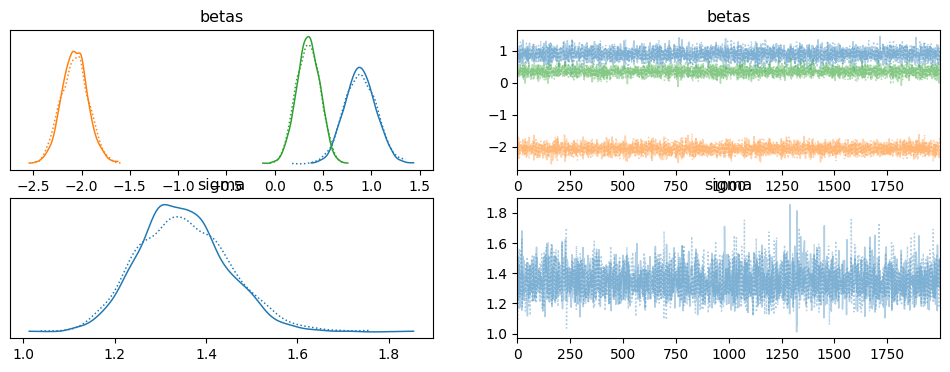

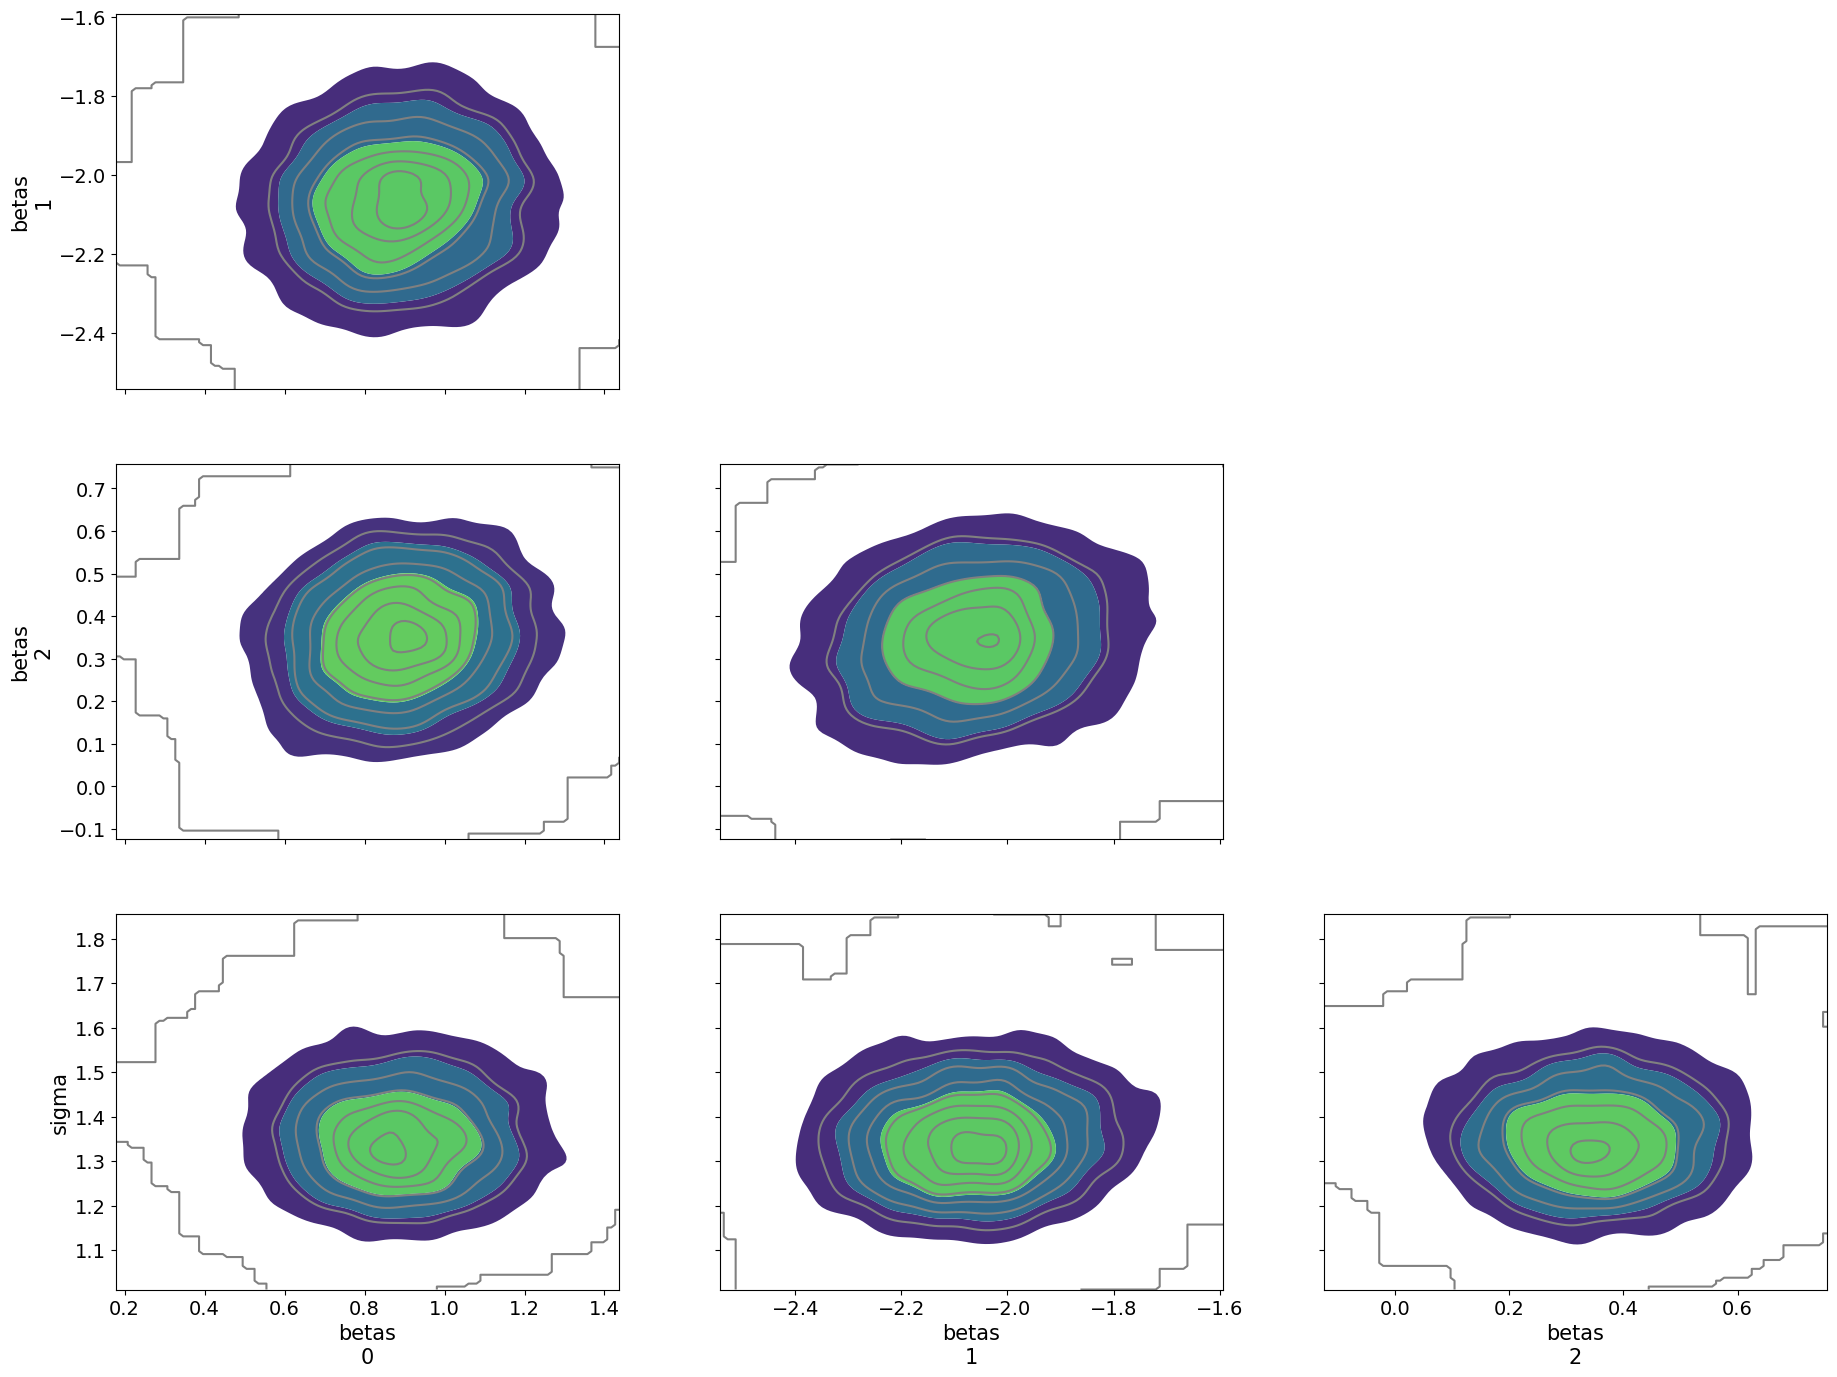

In [4]:
# Summarize the posterior
summary_df = az.summary(trace, var_names=["betas", "sigma"], round_to=2)
print(summary_df)

# Trace plots (posterior + sampling diagnostics)
az.plot_trace(trace, var_names=["betas", "sigma"]);

# Posterior corner plot
az.plot_pair(trace, var_names=["betas", "sigma"], kind='kde');

### Q3: perform robust Bayesian Linear Regression

Let $p(\tau_i)$ be $\require{cancel} \textrm{gamma}\big(\tau_i | \alpha = \frac{\nu}{2}, \overset{\textrm{rate}\xcancel{\textrm{scale}}}{\beta = \frac{\nu}{2}}\big)$ and let $p(y_i|\boldsymbol \beta, \tau,\tau_i)$ be $\mathcal{N}(y_i | \textbf{X} \boldsymbol \beta, \overset{\textrm{precision}}{\tau \times \tau_i})$.

- Return to your dataset and maniputate it to have some various outliers or find another dataset with some outlier data
- Use an appropriate prior for inference on $v$ if you have enough data to do so
- Use the posterior distributions of the $\tau_i$'s to identify data point "outliers"
- Use the posterior distributions of the $\sigma_i^{-2} = \tau \times \tau_i$ to create posterior distribuitions of the **influence** (the diagonals of the $H$ "hat" matrix $X^\top (X^\top D X)^{-1} X$ where $D_{ij}=0$ and $D_{ii} = \sigma^2_i$) and compare and contras some example "outlier" versus "non outlier" data points

- Provide inference with Bayesian posterior analysis and report MCMC diagnostics

#### [Optional] Q3 Extra: measurement error models?

What if $\textbf{x}_i = \textbf{x}_i^{true} + \eta_i, \eta_i \sim \mathcal{MVN}(\textbf{0}, \Sigma)$ for some kind of measurement error covariance structure $\Sigma$ and $\mathcal N (y_i| \textbf{X}^{true}\boldsymbol \beta, \sigma)$?
